# Метрики классификации

### 1. Бинарная классификация

Контест https://contest.yandex.ru/contest/55886

Как обычно для начала заимпортим все необходимые библиотеки. Если у вас не установлен какой-то из пакетов, то его можно поставить через ``pip``, ``conda``...

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, KFold, cross_validate
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import balanced_accuracy_score, average_precision_score
from sklearn.metrics import f1_score
import pickle, sys

Загрузите датасет и посмотрите на него. Разберитесь, какие фичи являются вещественными, а какие категориальными, где есть пропуски.

In [42]:
bin_clf_base = './'
df = pd.read_csv(bin_clf_base + "adult.csv")

In [43]:
df

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,22,Private,310152,Some-college,10,Never-married,Protective-serv,Not-in-family,White,Male,0,0,40,United-States,<=50K
32557,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32558,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32559,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K


Вы, наверное, уже поняли, что пропуски в датасете обозначены символом ``?``. Замените их все модой (наиболее часто встречающимся значением в столбце), пожалуйста.

In [44]:
for column in df.columns:
    df[column] = df[column].replace('?', pd.NA)
    mode = df[column].mode()[0]
    df[column] = df[column].fillna(mode)
df

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,Private,77053,HS-grad,9,Widowed,Prof-specialty,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,Private,186061,Some-college,10,Widowed,Prof-specialty,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,22,Private,310152,Some-college,10,Never-married,Protective-serv,Not-in-family,White,Male,0,0,40,United-States,<=50K
32557,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32558,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32559,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K


Пусть зарплата <=50К в год будет ``0``, иначе ``1``.

In [45]:
df['income']

0        <=50K
1        <=50K
2        <=50K
3        <=50K
4        <=50K
         ...  
32556    <=50K
32557    <=50K
32558     >50K
32559    <=50K
32560    <=50K
Name: income, Length: 32561, dtype: object

In [46]:
df['income'] = df['income'].map({'<=50K': 0, '>50K': 1, '<=50K.': 0, '>50K.': 1})

In [47]:
# Числовые признаки
numeric_features = ['age','fnlwgt','education.num','capital.gain','capital.loss','hours.per.week','income']

# Категориальные признаки
cat_features = ['workclass','education','marital.status','occupation','relationship','race','sex','native.country']

Заменим все категориальные признаками one-hot признаками, дропнув первый и добавив префикс-название соответствующей категориальной фичи.

In [48]:
for cat_feature in cat_features:
    one_hot = pd.get_dummies(df[cat_feature], drop_first=True, prefix=cat_feature)
    df = df.drop(cat_feature, axis=1)
    df = df.join(one_hot)

In [49]:
df.columns

Index(['age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss',
       'hours.per.week', 'income', 'workclass_Local-gov',
       'workclass_Never-worked', 'workclass_Private', 'workclass_Self-emp-inc',
       'workclass_Self-emp-not-inc', 'workclass_State-gov',
       'workclass_Without-pay', 'education_11th', 'education_12th',
       'education_1st-4th', 'education_5th-6th', 'education_7th-8th',
       'education_9th', 'education_Assoc-acdm', 'education_Assoc-voc',
       'education_Bachelors', 'education_Doctorate', 'education_HS-grad',
       'education_Masters', 'education_Preschool', 'education_Prof-school',
       'education_Some-college', 'marital.status_Married-AF-spouse',
       'marital.status_Married-civ-spouse',
       'marital.status_Married-spouse-absent', 'marital.status_Never-married',
       'marital.status_Separated', 'marital.status_Widowed',
       'occupation_Armed-Forces', 'occupation_Craft-repair',
       'occupation_Exec-managerial', 'occupation_Farming

Разделим на выборку на ``validation`` и ``train``:

In [50]:
y_col = 'income'
y = df[y_col]
X = df.loc[:, df.columns != y_col]
validation_size = 0.20
seed = 17

X_train, X_validation, Y_train, Y_validation = train_test_split(X, y,
    test_size=validation_size, random_state=seed)

In [51]:
Y_validation.shape

(6513,)

Предположим, что мы хотим сравнить поведение каких-то моделей на наших данных: например, логистической регрессии и CatBoostClassifier.

Но по каким критериям мы их будем сравнивать? Давайте посмотрим несколько вариантов.

**1.1. Время, память**. 

Некоторые модели учатся хорошо, но медленно. Из классических методов весьма неспешен SVM, а уж нейросети и вовсе можно учить часами, сутками и даже неделями. Но важна не только скорость обучения, но и скорость инференса. Если вы обучили модель у себя перед тем, как отдавать пользователям, вам может быть не так принципиально, сколько она училась; при этом у пользователя она должна скорее всего отрабатывать в режиме реального времени.

Размер модели тоже нередко оказывается важным, например, если вы собираетесь использовать её на мобильных устройствах.

Давайте посмотрим, как быстро учатся, как быстро предсказывают и какой размер имеют следующие модели*

* `sklearn.dummy.DummyClassifier(strategy="most_frequent")`
* `sklearn.linear_model.LogisticRegression()`
* `sklearn.discriminant_analysis.LinearDiscriminantAnalysis()`
* `sklearn.neighbors.KNeighborsClassifier()`
* `sklearn.tree.DecisionTreeClassifier()`
* `sklearn.naive_bayes.GaussianNB()`
* `sklearn.ensemble.RandomForestClassifier(n_estimators=100, max_features=3)`
* `sklearn.neural_network.MLPClassifier()`
* `sklearn.ensemble.AdaBoostClassifier(n_estimators=100)`
* `sklearn.ensemble.GradientBoostingClassifier(n_estimators=100, max_features=3)`
* `sklearn.ensemble.ExtraTreesClassifier(n_estimators=100)`
* `xgboost.XGBClassifier(n_estimators=100, verbosity=0, use_label_encoder=False)`
* `catboost.CatBoostClassifier(iterations=100, silent=True)`

Для всех рассматриваемых моделей:

* нарисуйте boxplot'ы времени обучения и boxplot'ы предсказания, посчитав их по кроссвалидации с 10 фолдами на `(X_train, Y_train)` с помощью атрибутов `fit_time` и `score_time` объекта результатов кроссвалидации;
* посчитайте размеры моделей. Сделать это можно, например, с помощью:

```
import pickle, sys

model.fit(X_train, Y_train)
p = pickle.dumps(model)
model_sizes.append(sys.getsizeof(p))
```

Для времён обучения вас может получиться что-то подобное:

In [52]:
names = ['DummyClassifier', 
            'LogisticRegression', 
            'LDA', 
            'KNN', 
            'DecisionTree', 
            'GNB', 
            'RF', 
            'MLP',
            'AdaBoost', 
            'GradientBoosting', 
            'ExtraTrees', 
            'XGB', 
            'CatBoost']
models = [
    DummyClassifier(strategy="most_frequent"),
    LogisticRegression(),
    LinearDiscriminantAnalysis(),
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    GaussianNB(),
    RandomForestClassifier(n_estimators=100, max_features=3),
    MLPClassifier(),
    AdaBoostClassifier(n_estimators=100),
    GradientBoostingClassifier(n_estimators=100, max_features=3),
    ExtraTreesClassifier(n_estimators=100),
    XGBClassifier(n_estimators=100, verbosity=0, use_label_encoder=False),
    CatBoostClassifier(iterations=100, silent=True)
]

models = dict(zip(names, models))
models

{'DummyClassifier': DummyClassifier(strategy='most_frequent'),
 'LogisticRegression': LogisticRegression(),
 'LDA': LinearDiscriminantAnalysis(),
 'KNN': KNeighborsClassifier(),
 'DecisionTree': DecisionTreeClassifier(),
 'GNB': GaussianNB(),
 'RF': RandomForestClassifier(max_features=3),
 'MLP': MLPClassifier(),
 'AdaBoost': AdaBoostClassifier(n_estimators=100),
 'GradientBoosting': GradientBoostingClassifier(max_features=3),
 'ExtraTrees': ExtraTreesClassifier(),
 'XGB': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=No

In [53]:
fit_time = {}
predict_time = {}
train_accuracy = {}
test_accuracy = {}
model_sizes = []
for name in models.keys():
    model = models[name]
    cv_results = cross_validate(model, X_train, Y_train, cv=10, scoring='accuracy', return_train_score=True)
    p = pickle.dumps(model)
    model_sizes.append(sys.getsizeof(p))
    fit_time.update({name: sum(cv_results['fit_time'])})
    predict_time.update({name : sum(cv_results['score_time'])})
    train_accuracy.update({name : cv_results['train_score'].mean()})
    test_accuracy.update({name : cv_results['test_score'].mean()})

C:\Users\User\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\User\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

KeyboardInterrupt: 

In [ ]:
results_df = pd.DataFrame({
    'names' : fit_time.keys(),
    'fit_time' : fit_time.values(),
    'train_accuracy' : train_accuracy.values(),
    'test_accuracy' : test_accuracy.values()
})
results_df

,names,fit_time,train_accuracy,test_accuracy
0,DummyClassifier,0.037367,0.758024,0.758024
1,LogisticRegression,3.787151,0.794866,0.794763
2,LDA,21.537930,0.842594,0.841063
3,KNN,0.205976,0.831294,0.771767
4,DecisionTree,2.185890,1.000000,0.812040
5,GNB,0.465586,0.793049,0.792997
6,RF,31.592021,0.999962,0.850315
7,MLP,46.716579,0.758352,0.756489
8,AdaBoost,26.453385,0.865330,0.863176
9,GradientBoosting,3.331112,0.855314,0.854192


In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

# Данные
#X, y = load_data()  # Подставьте свои данные
#X_train, X_test, y_train, y_test = X#train_test_split(X, y, test_size=0.2, random_state=42)

# Параметры
step = 1  # Шаг увеличения числа деревьев
max_trees = 300  # Максимальное число деревьев
f1_scores = []  # Сохраняем F1-меры
trees_range = list(range(10, max_trees + 1, step))

# Обучение моделей с разным количеством деревьев
for n_trees in trees_range:
    model = RandomForestClassifier(n_estimators=n_trees, random_state=42)
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_validation)
    f1 = f1_score(Y_validation, y_pred, average='weighted')  # Для многоклассовой задачи
    f1_scores.append(f1)

# Анализ стабилизации F1
for i in range(1, len(f1_scores)):
    delta = abs(f1_scores[i] - f1_scores[i - 1])
    if delta < 0.01:  # Стабилизация
        print(f"F1-мера стабилизируется начиная с {trees_range[i]} деревьев (изменение: {delta:.5f})")
        break


KeyboardInterrupt: 

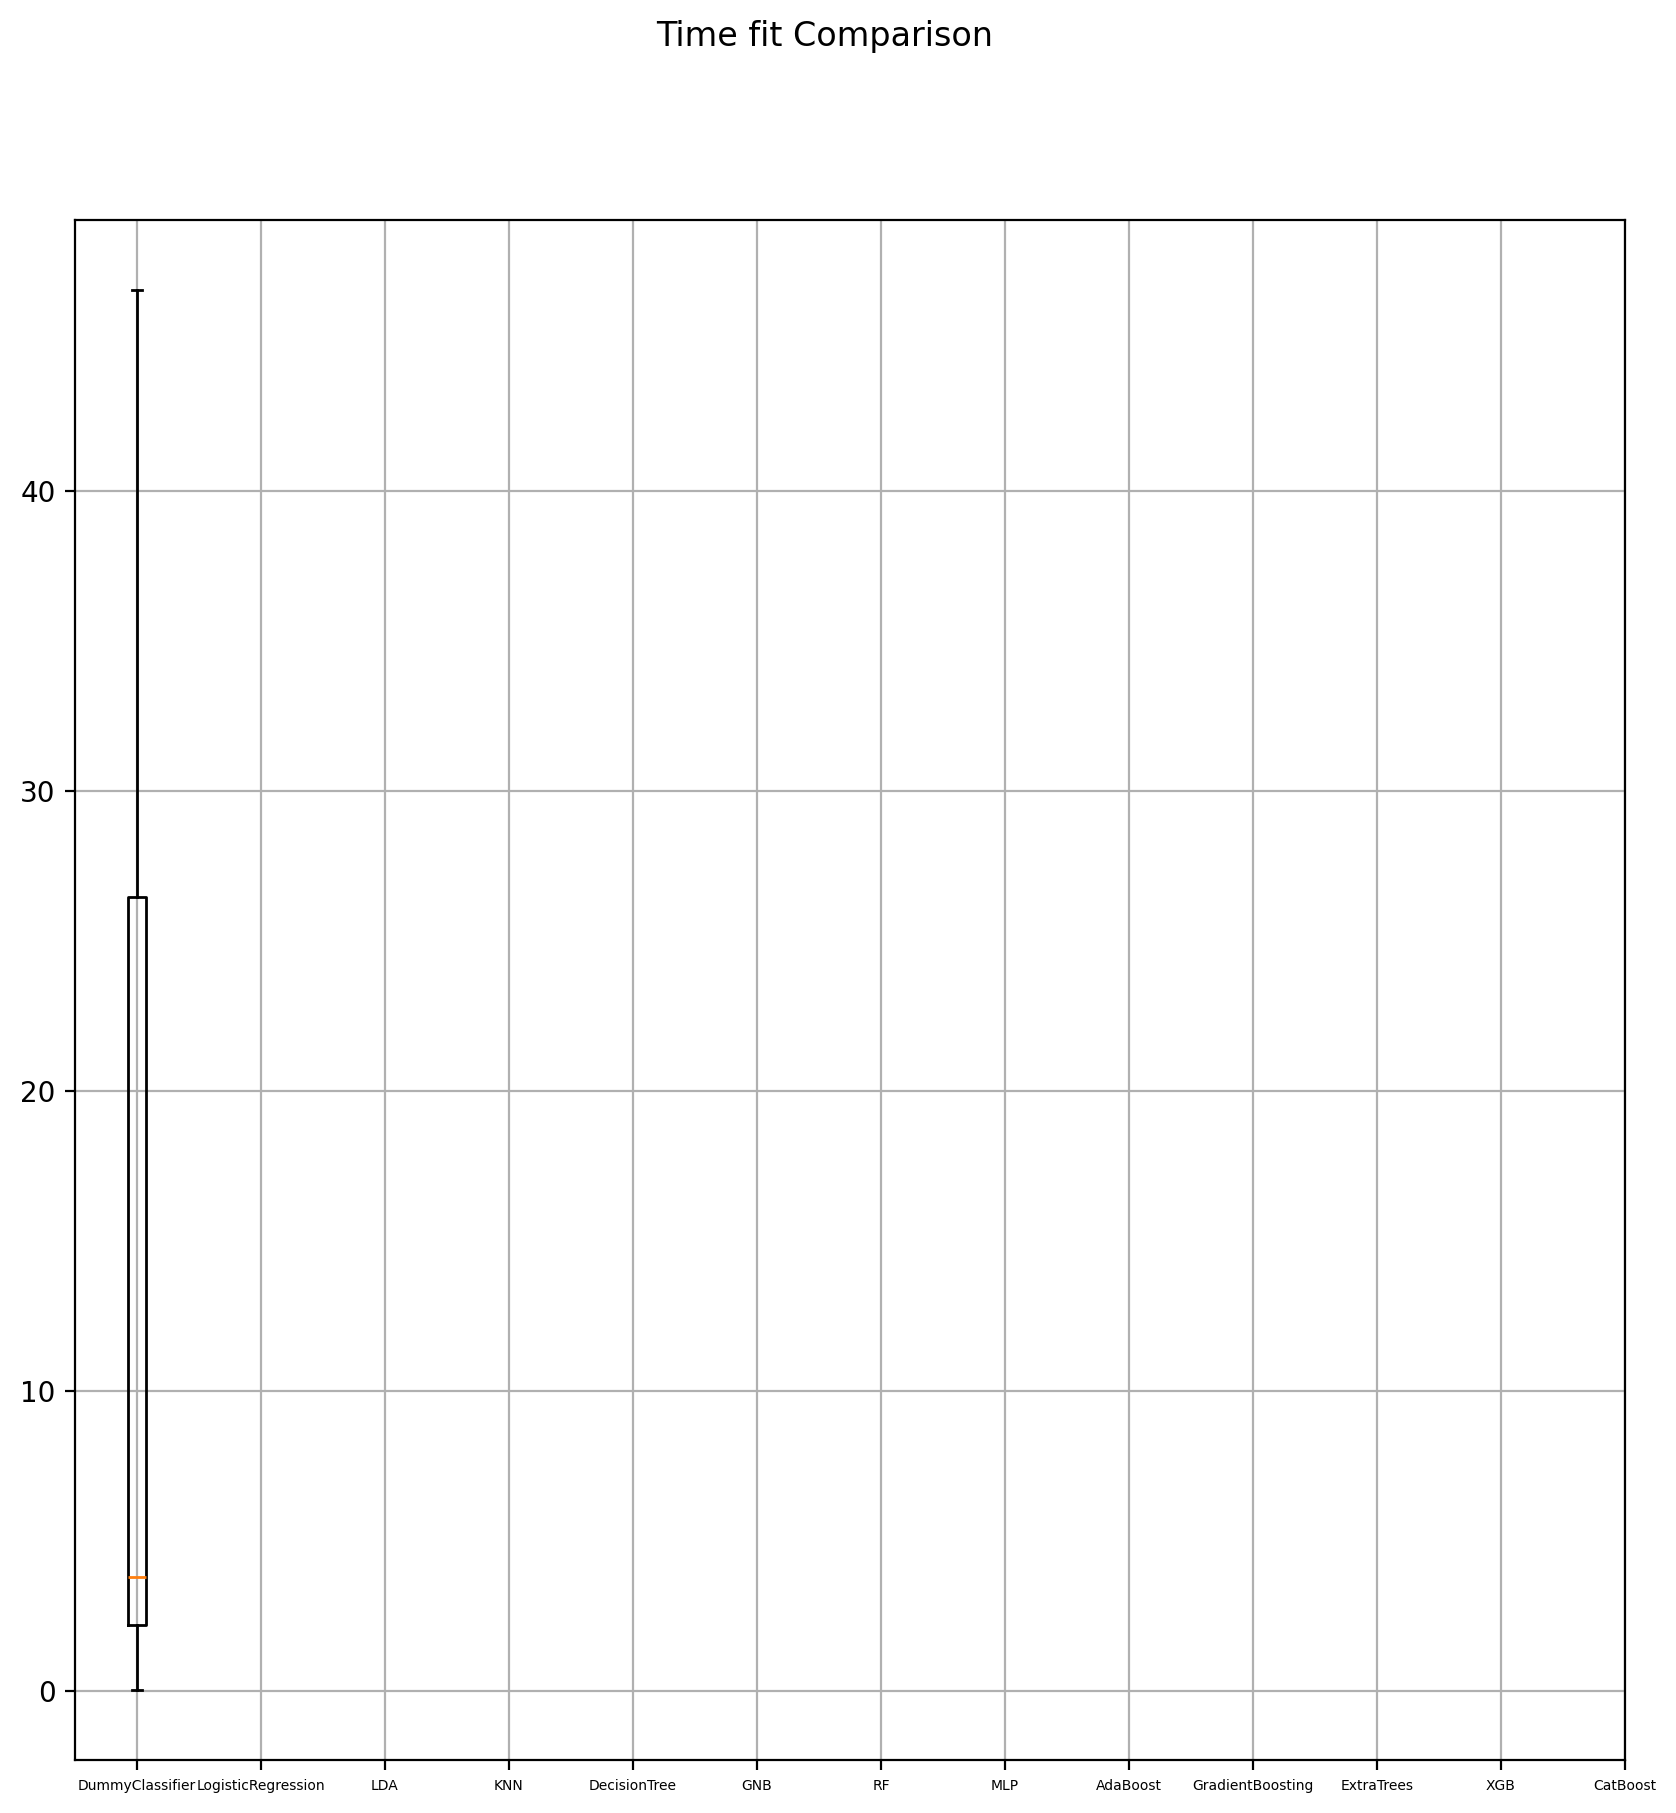

In [ ]:
fig = plt.figure(figsize=(10, 10), dpi=200)
fig.suptitle('Time fit Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results_df.fit_time)
ax.set_xticks(range(1, len(results_df.names) + 1))
ax.set_xticklabels(results_df.names, fontsize=5)
plt.grid()

plt.show()

Видно, что есть алгоритмы, которые сошлись на том, чтобы предсказывать константу или гораздо чаще предсказывать самый популярный класс в обучающей выборке: ``Dummy``, ``KNN``, ``NB``, ``MLP``. Для таких алгоритмов нужно дальнейшая настройка. Будьте внимательны, когда берете одну из этих моделей без донастройки.

Давайте, рассмотрим какой-нибудь пример отдельно.
Например, возьмем ``CatBoostClassifier``, т.к. он быстро обучается и выдает неплохое качество по обеим метрикам.

In [ ]:
cat_boost = CatBoostClassifier(iterations=100, silent=True)
cat_boost.fit(X_train, Y_train)
predictions = cat_boost.predict(X_validation)
print("Accuracy: %s%%" % (100*accuracy_score(Y_validation, predictions)))
print("Precision: %s%%" % (100*precision_score(Y_validation, predictions)))
print("Recall: %s%%" % (100*recall_score(Y_validation, predictions)))
print("F1: %s%%" % (100*f1_score(Y_validation, predictions)))
print("Balanced accuracy: %s%%" % (100*balanced_accuracy_score(Y_validation, predictions)))
print(classification_report(Y_validation, predictions))

Accuracy: 87.57868877629356%
Precision: 77.63457164518574%
Recall: 66.57997399219767%
F1: 71.68358417920896%
Balanced accuracy: 80.32516287549582%
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      4975
           1       0.78      0.67      0.72      1538

    accuracy                           0.88      6513
   macro avg       0.84      0.80      0.82      6513
weighted avg       0.87      0.88      0.87      6513



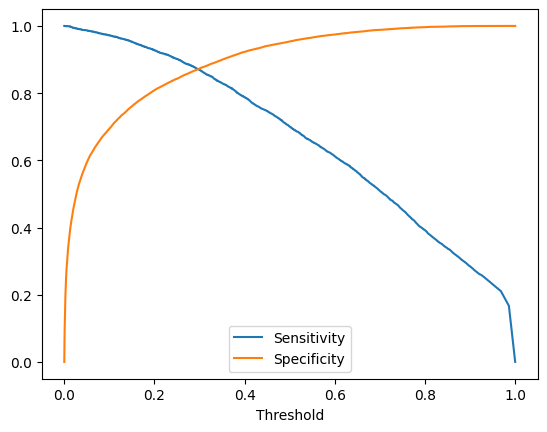

'Threshlod value with max sum sensitivity and specificity is 0.25158886767421634'

In [ ]:
from sklearn.metrics import roc_curve

# Вероятности положительного класса
#cat_boost = CatBoostClassifier(iterations=100, silent=True)
y_proba = cat_boost.predict_proba(X_train)[:, 1]

# Вычисление ROC-кривой
fpr, tpr, thresholds = roc_curve(Y_train, y_proba)

# Sensitivity = TPR, Specificity = 1 - FPR
plt.plot(thresholds, tpr, label='Sensitivity')
plt.plot(thresholds, 1 - fpr, label='Specificity')
plt.xlabel('Threshold')
plt.legend()
plt.show()

sensitivity = tpr
specificity = 1 - fpr

sens_spec_sum = sensitivity + specificity

max_idx = np.argmax(sens_spec_sum)
f'Threshlod value with max sum sensitivity and specificity is {thresholds[max_idx]}'

Без всякого тюнинга получилли хорошие результаты.

In [ ]:
pd.crosstab(predictions, Y_validation, rownames = ['Predicted'], colnames =['Actual'])

Actual,0,1
Predicted,,
0,4680,514
1,295,1024


Как видим, не всегда ``accuracy`` показывает истинное качество модели, для сильно несбалансированных классов лучше использовать ``f1`` меру или ``balanced_accuracy``

Всегда нужно представлять эту таблицу в голове.

**1. (0.5 балла)** В качестве разминки **откройте первое задание в Контесте и выберите модель, которая будет очень быстро учиться, но ужасно медленно предсказывать**. Вы ведь понимаете, почему это так?

Мы привыкли, что слишком сложные модели плохи тем, что они переобучаются, но ведь они и попросту слишком ресурсозатратны при, возможно, не самом великом качестве.

Для модели CatBoostClassifier с 10, 20,..., 100 деревьями посчитайте:

* f1_score с помощью кроссвалидации с 10 фолдами на `(X_train, Y_train)`; 
* времена обучения;
* времена инференса;
* размер модели.

Возможно, поведение времени инференса будет для вас немного неожиданным, а вот время обучения и размер модели более или менее линейно растут — в отличие от f1-меры.

**2. (0.5 балла)** Найдите и зашлите в контест то число деревьев (кратное 10), начиная с которого f1-мера меняется уже только в третьем знаке после запятой.

In [ ]:
model_sizes

[171, 363, 256, 274, 397, 152, 677, 598, 252, 557, 680, 801, 117]

**1.2. Метрики бинарной классификации**

Если вы читали [соответствующую главу учебника](https://academy.yandex.ru/handbook/ml/article/metriki-klassifikacii-i-regressii), то знаете, что метрик довольно много. Среди них:

- accuracy (число верно угаданных меток);
- precision (доля верно угаданных единиц среди всех предсказанных нами единиц);
- recall (доля угаданных нами единиц среди всех единиц);
- F-мера:

$$F_1 = 2\frac{Recall \cdot Precision}{Recall + Precision}$$

**Вопрос на подумать**. Попробуйте придумать классификатор с очень хорошим precision и очень плохим recall, а также обратный пример: с очень хорошим recall и очень плохим precision. Это может натолкнуть вас на мысль, что смотреть только precision или только recall — плохая идея.

Для метрик accuracy и f1 постройте boxplot'ы значений этих метрик по кроссвалидации с 10 фолдами на `(X_train, Y_train)`. У вас может получиться что-то такое:

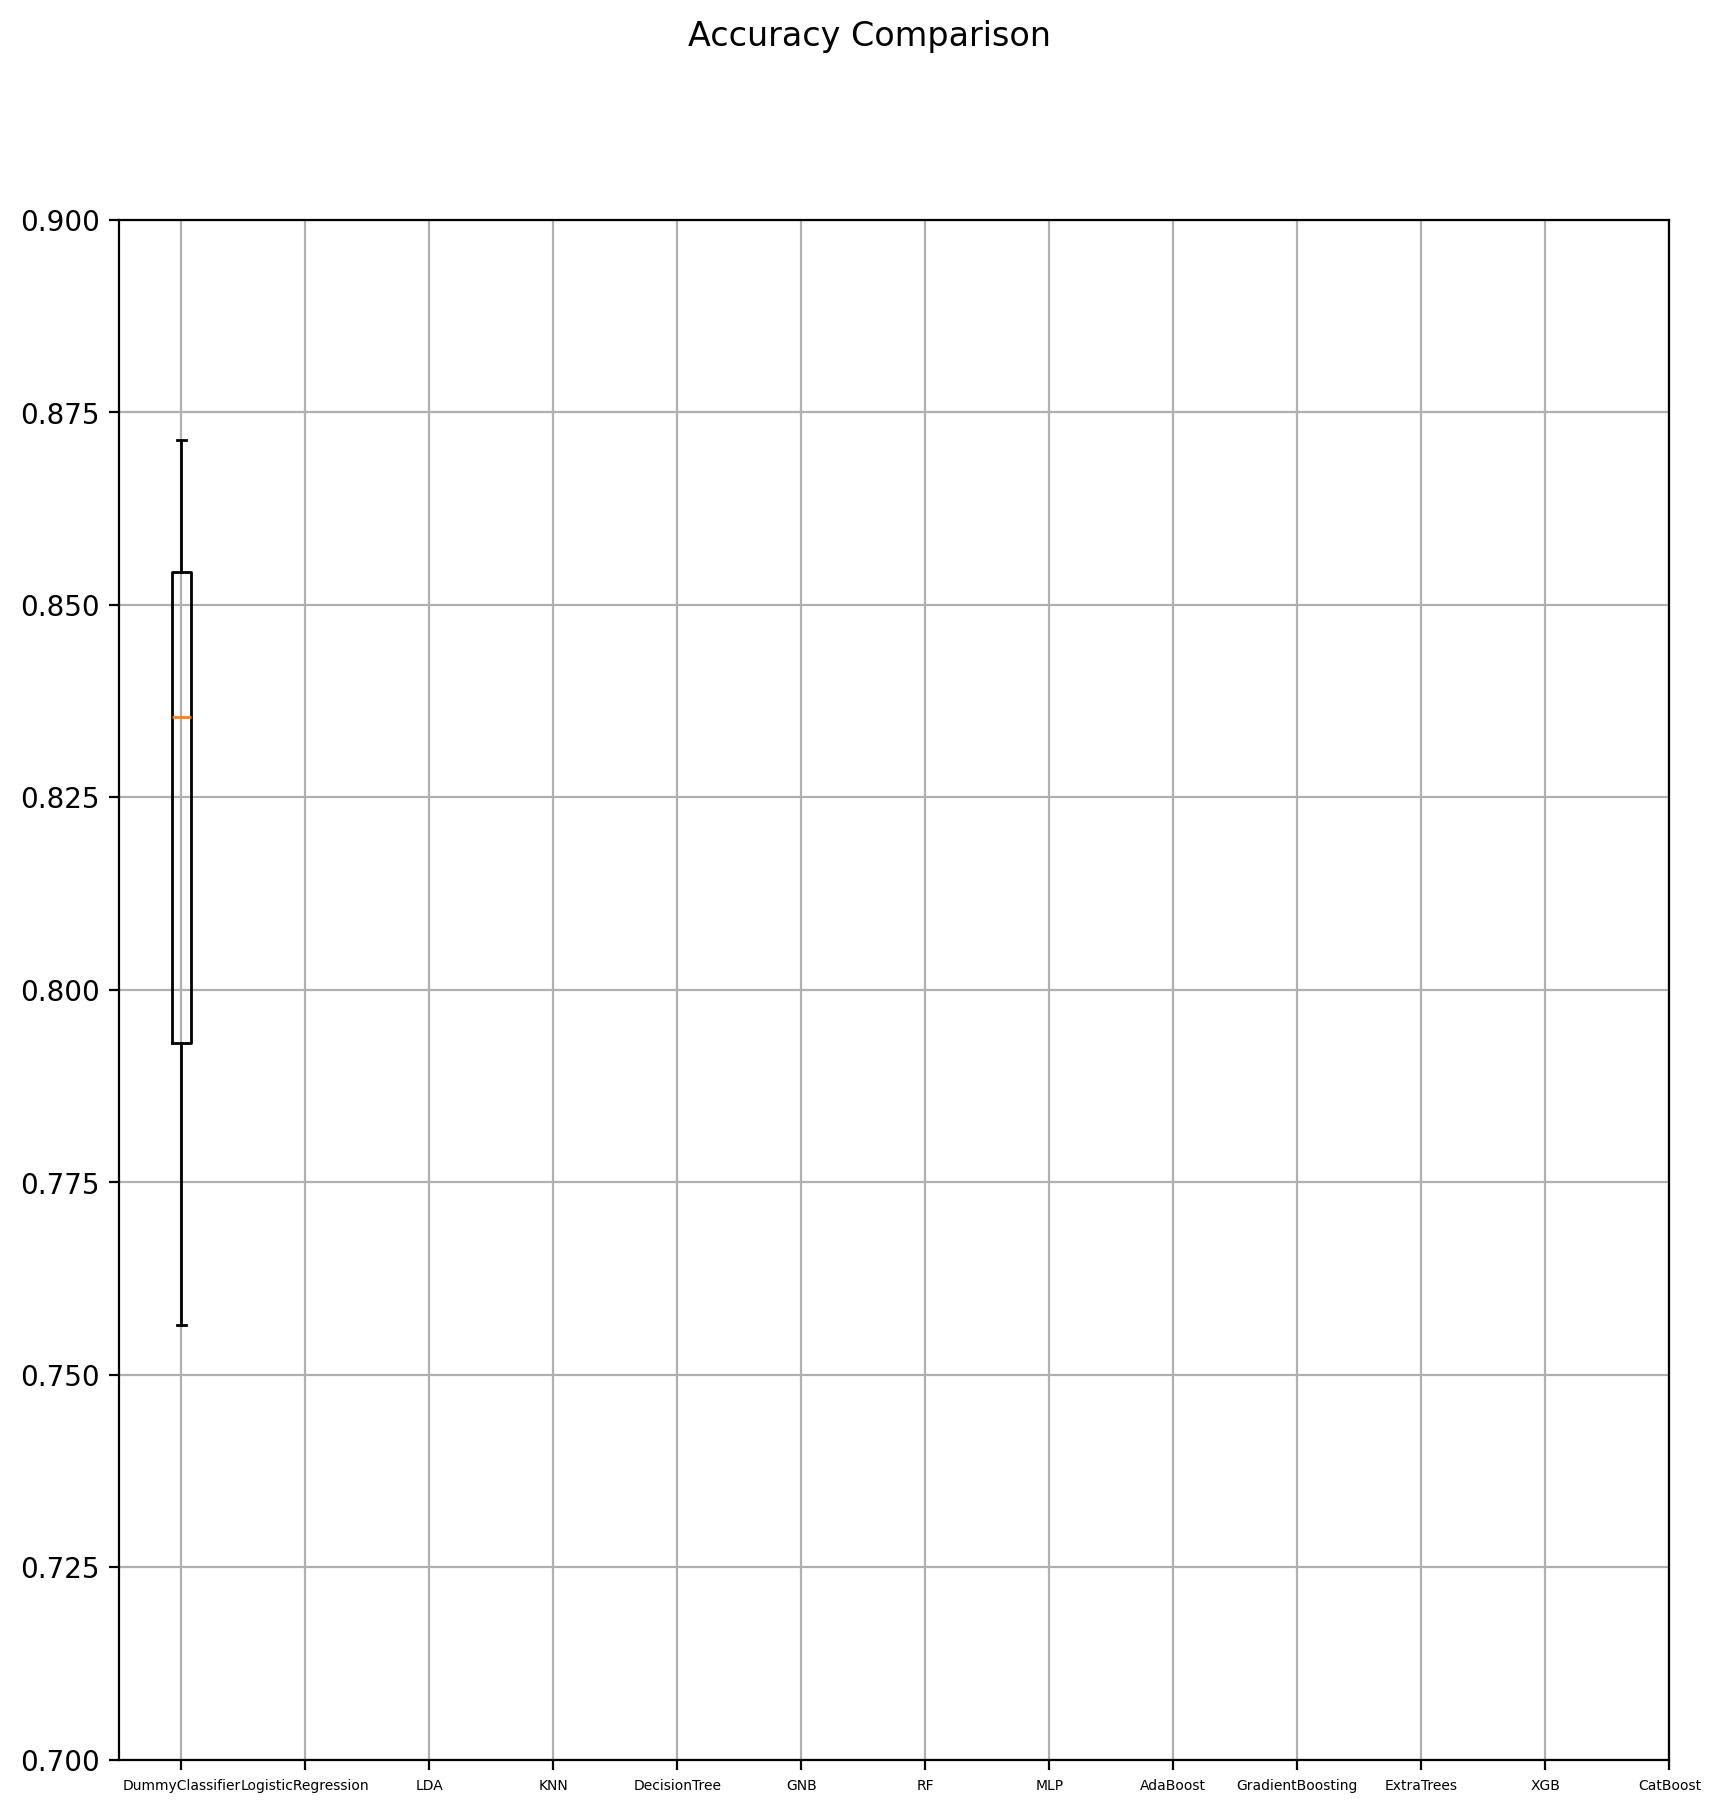

In [ ]:
fig = plt.figure(figsize=(10, 10), dpi=200)
fig.suptitle('Accuracy Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results_df.test_accuracy)
ax.set_xticks(range(1, len(names) + 1))
ax.set_xticklabels(names, fontsize=5)
plt.ylim((0.7, 0.9))
plt.grid()
plt.show();

AttributeError: 'DataFrame' object has no attribute 'test_f1'

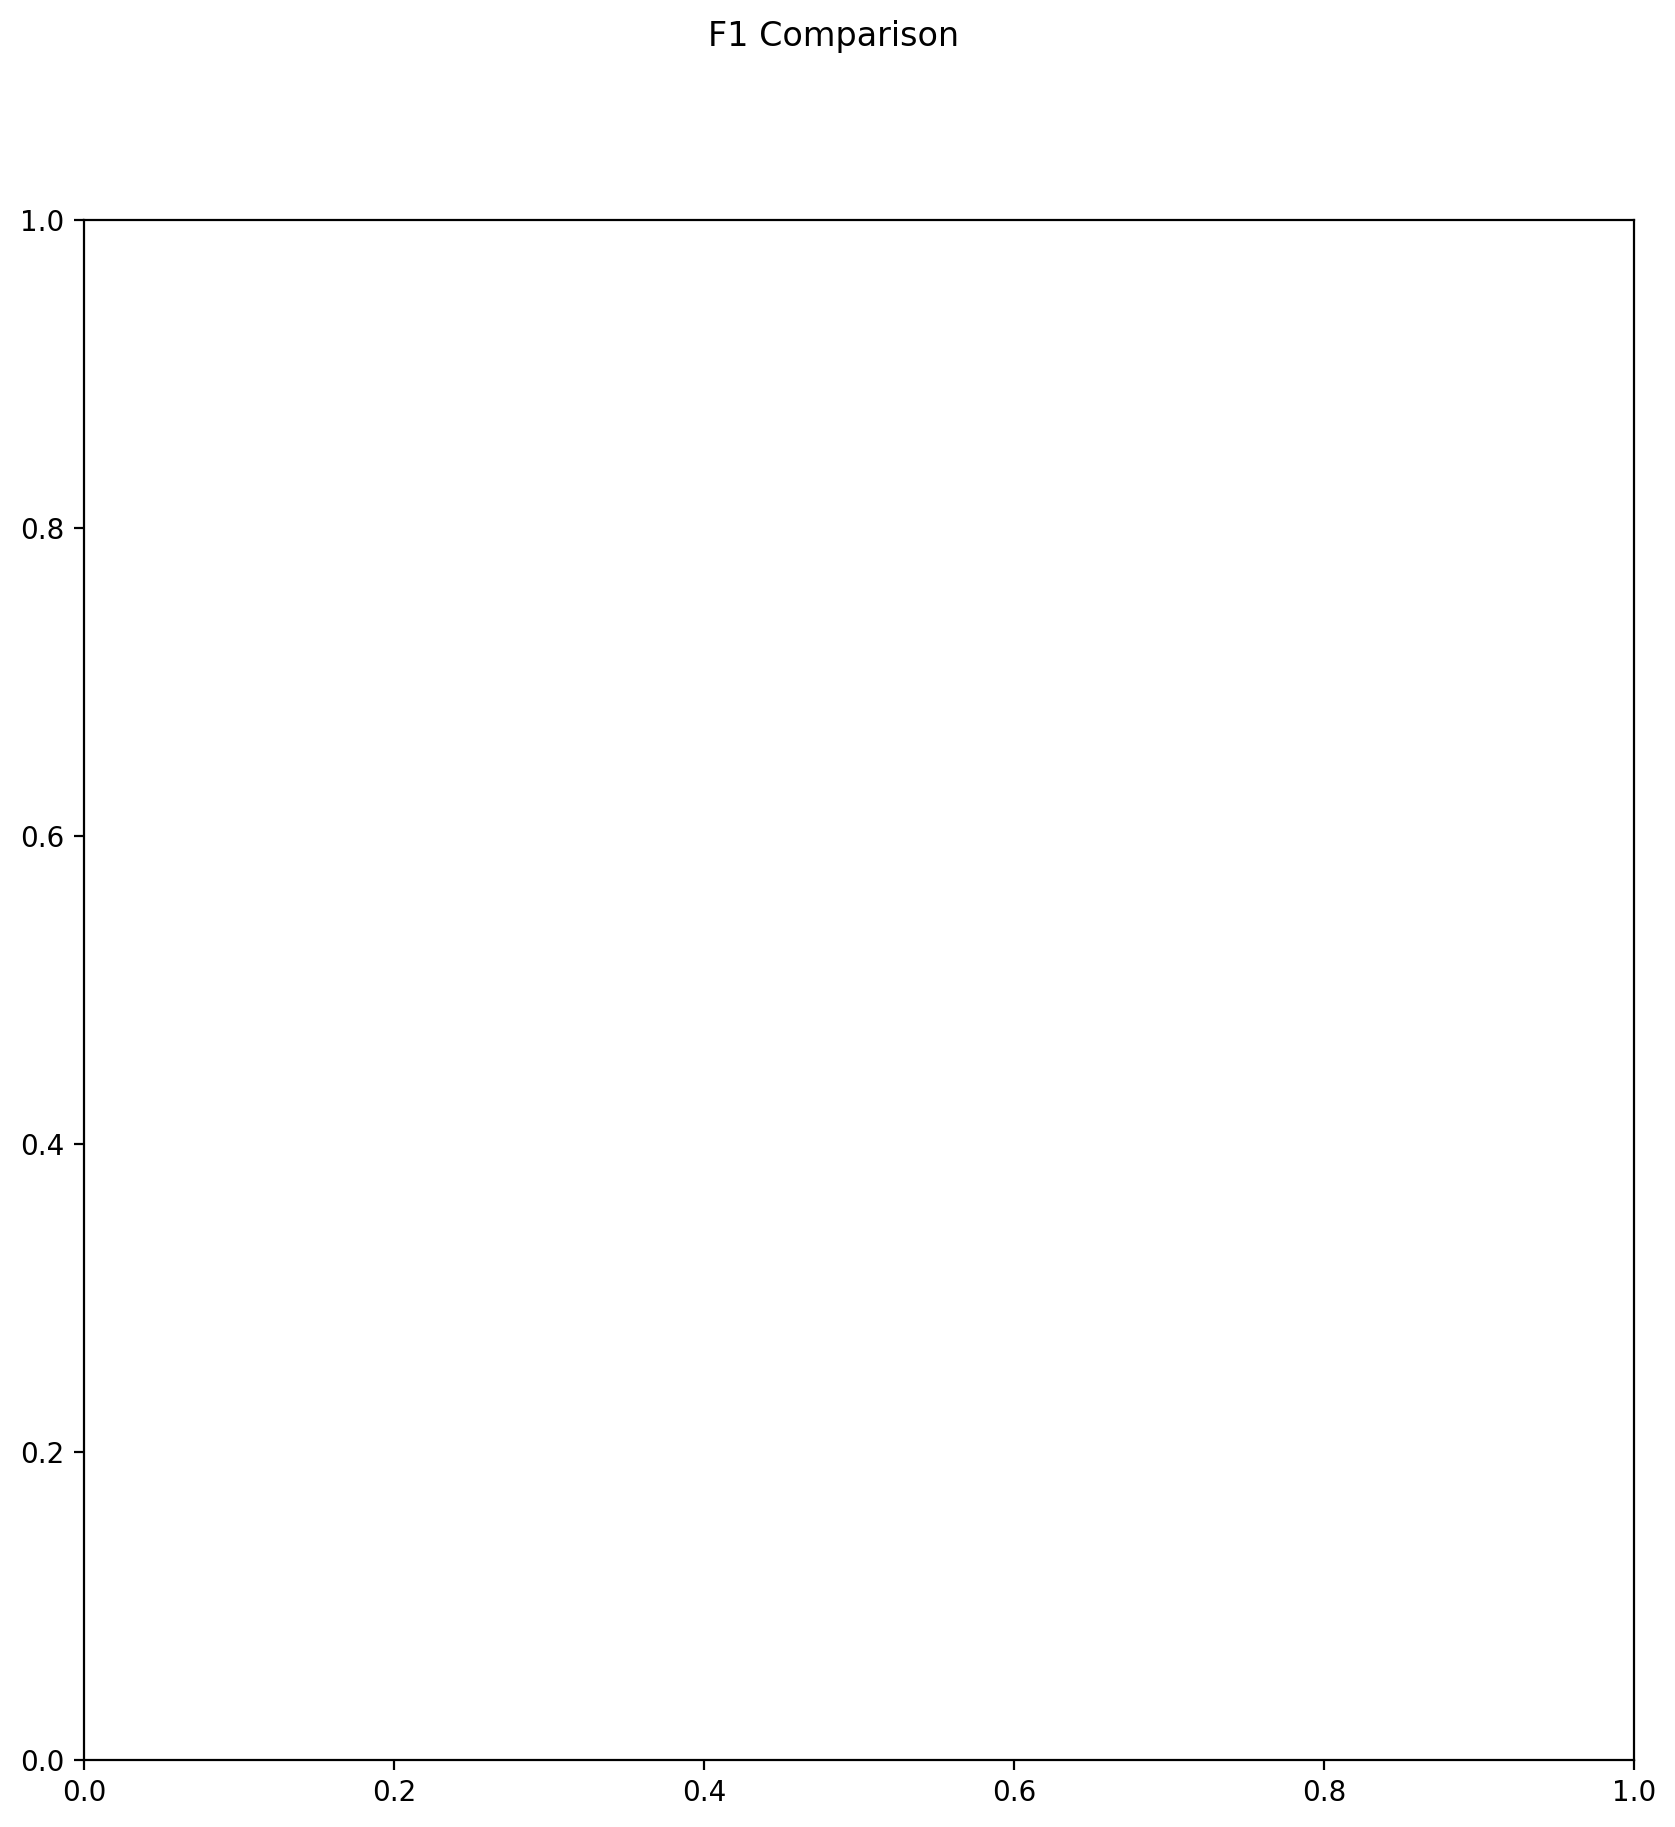

In [ ]:
fig = plt.figure(figsize=(10, 10), dpi=200)
fig.suptitle('F1 Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results_df.test_f1)
ax.set_xticklabels(names, fontsize=5)
plt.ylim((0.3, 0.75))
plt.grid()
plt.show();

Предлагаем ещё посмотреть на Precision и Recall разных классификаторов (в этот раз мы их обучали на train, а метрики смотрели на validation). Некоторые из точек, впрочем, могут скакать от запуска к запуску (как думаете, какая из них особенно нестабильна?).

Выше мы чуть-чуть цинично нарушили обещание сравнивать разные модели на валидационной выборке, но зато мы поняли одну важную вещь: на самом деле, качество некоторых моделей довольно существенно меняется от фолда к фолду. Для нейросетей, которые обучаются с помощью стохастической оптимизации (из случайной инициализации) и у которых поверхность функции потерь обычно устроена сложно, всё ещё хуже, потому что результаты могут существенно отличаться от запуска к запуску даже на одном и том же датасете.

Обучите 10 раз `MLPClassifier` на `(X_train, Y_train)` и посчитайте `accuracy_score` на `(X_validation, Y_validation)`. Убедитесь, что значения бывают весьма разными.

In [ ]:
## <YOUR CODE HERE>

Так что если вы хотите сравнить две нейросетевых модели, мало обучить их по одному разу и сравнить метрики. Нужно проводить несколько экспериментов и считать статзначимость!

**1.3. Метрика не приходит одна**

Довольно приятно работать с $F_1$-мерой и думать, что `Precision` и `Recall` никому не нужны, но на деле не всегда получается обойтись одной метрикой.

Скажем, в медицине нередки задачи, в которых нужно максимизировать `Precision` при том, что `Recall` не меньше какого-то значения (например, 0.95). Для нашей задачи это означало бы, что мы отловили не менее 95% людей с высоким доходом и при этом как можно меньше приписываем класс 1 людям с низким доходом. Наверное, это могло бы быть актуально для таргетирования какого-нибудь спецпредложения банка для премиальных клиентов: нам хочется как можно больше охватить богатых и как можно меньше спецпредложений выдать не столь богатым клиентам (не воспринимайте всерьёз этот пример).

**3. (1 балл)** А чтобы мы убедились, что вы поняли, что такое Precision и Recall, найдите, какое минимальное значение может иметь Recall на `(X_validate, Y_validate)`, если Precision >= 0.9 и Accuracy >= 0.9, и загрузите в Контест.

In [ ]:
X_validation.shape

(6513, 97)

In [ ]:
np.sum(Y_validation == 0), np.sum(Y_validation == 1)

(4975, 1538)

**1.4. Волшебный квадратик**

![alt text](https://yastatic.net/s3/ml-handbook/admin/6_1_30cbee6683.png)

Многие важные метрики так или иначе выражаются через сущности из волшебного квадратика.

- **TP = True Positives** — число объектов класса 1, которым верно (true) приписали класс 1 (positive);
- **FP = False Positives** — число объектов класса 0, которым неверное (false) приписали класс 1 (positive);
- **FN = False Negatives** — число объектов класса 1, которым неверно (false) приписали класс 0 (negatives);
- **TN = True Negatives** — число объектов класса 0, которым верно (true) приписали класс 0 (negatives).

Чувствительность:

$$Sensitivity = \frac{TP}{P} = \frac{TP}{TP + FN}$$

Специфичность:

$$Specificity = \frac{TN}{N} = \frac{TN}{FP + TN}$$

Sensitivity вы, на самом деле, уже встречали выше (где?!), и она показывает, насколько наш классификатор чувствителен к объектам класса 1. Specificity же говорит о том, насколько модель способна не приписывать попусту класс 1 тем, кто его не достоин (например, если речь идёт об определении болезни, то нам, наверное, хочется ставить поменьше положительных диагнозов тем, кто не болен).

Если же мы хотим иметь дело с одной метрикой, то мы можем взять

$$balanced\_accuracy = \frac{Sensitivity + Specificity}{2}$$

*Вопрос на засыпку*. В самой первой лабораторной вы уже имели дело с `balanced_accuracy`, но там она определялась по-другому. Или это всё-таки одно и то же?

**4. (1 балл)** Найдите, 

(а) какое минимальное значение может иметь Accuracy на `(X_validate, Y_validate)`, если balanced_accuracy >= 0.9, и 

(б) какое максимальное значение может иметь Accuracy на `(X_validate, Y_validate)`, если balanced_accuracy <= 0.9, и загрузите в Контест

Также очень важными штуками являются True Positive Rate (TPR) и False Positive Rate (FPR):

$$TPR = \frac{TP}{TP + FN} = Sensitivity$$

$$FPR = \frac{FP}{FP + TN} = 1 - Specificity$$

Первое из них вы тоже уже видели (да сколько можно-то?!), а второе говорит о том, какую долю объектов класса 0 мы классифицировали неправильно.

**1.5. Предсказание вероятностей и AUC ROC**

Многие классификаторы умеют предсказывать "вероятности", то есть некоторые числа от 0 до 1, которые могут служить оценкой степени принадлежности объекта к некоторому классу. Как мы уже знаем, это не всегда настоящие вероятности, но, по крайней мере, чем больше предсказанная "вероятность", тем скорее мы отнесём объект к классу 1. Возникает два вопроса:

1) как выбирать отсечку, выше которой мы приписываем объекту класс 1?

2) можно ли оценить "вероятности" сами по себе, до того, как мы выбрали отсечку?

Начнём со второго. Для оценки предсказанных "вероятностей" и даже не только вероятностей, а и логитов тоже, есть замечательная метрика **AUC ROC**.

Давайте разберёмся, что это такое. И начнём с **roc-кривой**, её смысл следующий. Пусть $\widehat{p}_i$ — предсказанные "вероятности", $y_i$ — истинные метки. Предположим, что наши точки выборки отсортированы в порядке неубывания "вероятностей", то есть

$$\widehat{p}_i\leq\widehat{p}_2\leq\ldots\leq\widehat{p}_N$$

Давайте будем смотреть на различные отсечки $q\in[0,1]$. Каждая из них будет давать свой классификатор $\widehat{y}_i = \mathbb{I}[\widehat{p}_i \geq q]$, а у каждого из них будет своя пара $(FPR(q), TPR(q))$. Ясно следующее:

- $(FPR(0), TPR(0)) = (0, 0)$, а $(FPR(1), TPR(1)) = (1, 1)$;
- с ростом $q$ и FPR, и TPR не убывают, потому что мы больше объектов относим к классу 1;
- при $\widehat{p}_i\leq q < \widehat{p}_{i+1}$ значение $(FPR(q), TPR(q))$ одинаково.

Поэтому множество, состоящее из всех точек $(FPR(q), TPR(q))$, — это ступенчатая кривая, которая карабкается из точки $(0,0)$ в точку $(1,1)$ (точней сказать, ступеньки могут быть скошены, если среди "вероятностей" есть одинаковые).

Сейчас вам предстоит написать несколько облегчённую функцию `roc_from_scratch`, которая принимает на вход `probabilities` ("вероятности" положительного класса), `y_test` (вектор из 0 и 1, соответствующие правильным меткам) и `partitions` (количество отсечек). Функция будет возвращать numpy array размерности `(partitions+1, 2)`, в `i`-й (с нуля) строке которого стоит пара 

$$\left(FPR\left(\frac{i}{partitions}\right), TPR\left(\frac{i}{partitions}\right)\right)$$

In [ ]:
def roc_from_scratch(probabilities, y_test, partitions=100):
    #YOUR CODE GOES HERE
    return roc


Посмотрим на реализацию. У вас должно получиться что-то такое

Text(0, 0.5, 'True Positive Rate')

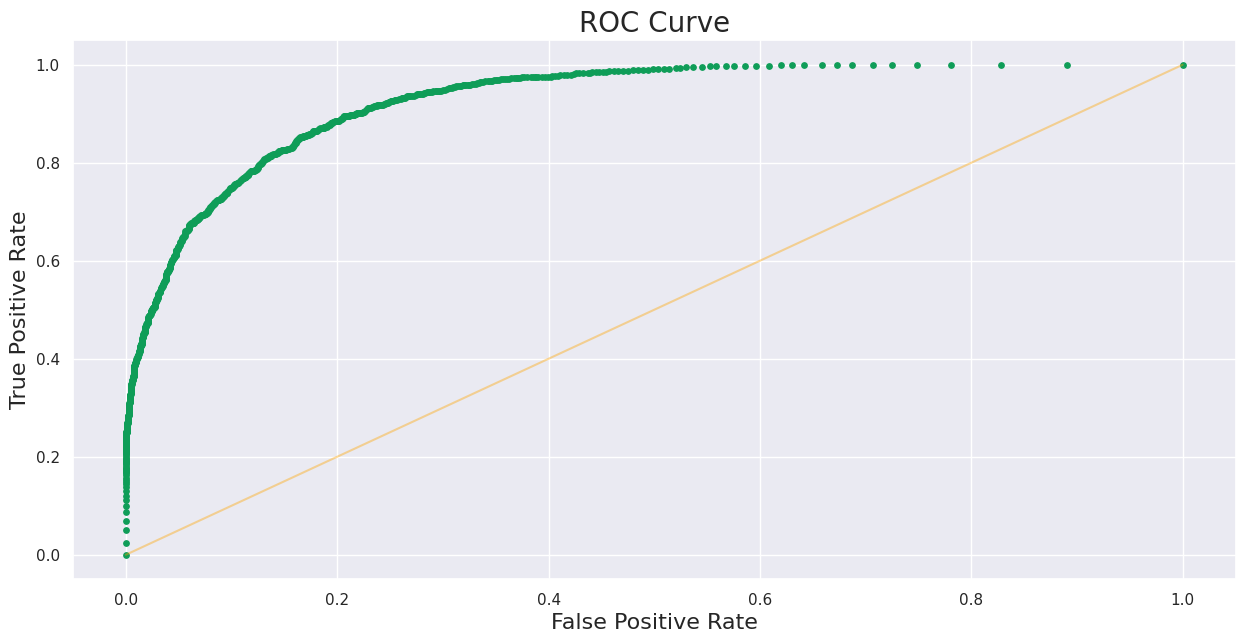

In [ ]:
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set()
plt.figure(figsize=(15,7))

cat_boost = CatBoostClassifier(iterations=100, silent=True)
cat_boost.fit(X_train, Y_train)
predictions_probs = cat_boost.predict_proba(X_validation)

ROC = roc_from_scratch(predictions_probs[:, 1], Y_validation, partitions=1000)
plt.scatter(ROC[:,0],ROC[:,1],color='#0F9D58',s=15)
plt.plot([0, 1], [0, 1], alpha=0.4, c='orange')
plt.title('ROC Curve',fontsize=20)
plt.xlabel('False Positive Rate',fontsize=16)
plt.ylabel('True Positive Rate',fontsize=16)

У хорошего классификатора FPR растёт медленно, а TPR быстро, поэтому roc-кривая будет красивым горбиком над диагональю единичного квадрата. Это можно померить численно с помощью **AUC** — площади под roc-кривой. Можно доказать, что если все $\widehat{p}_i$ различны, то **AUC** пропорционален доле верно упорядоченных пар:

$$\frac1{\sum_{i,j}\mathbb{I}[y_i < y_j]}\sum_{i,j}\mathbb{I}[y_i < y_j]\mathbb{I}[\widehat{p}_i < \widehat{p}_j].$$

(если есть одинаковые, то формула чуть сложнее; подробнее можно почитать [в статье Александра Дьяконова](https://dyakonov.org/2017/07/28/auc-roc-%D0%BF%D0%BB%D0%BE%D1%89%D0%B0%D0%B4%D1%8C-%D0%BF%D0%BE%D0%B4-%D0%BA%D1%80%D0%B8%D0%B2%D0%BE%D0%B9-%D0%BE%D1%88%D0%B8%D0%B1%D0%BE%D0%BA/))

Грубо говоря, эта метрика показывает, насколько порядок на объектах, задаваемый "вероятностями", похож на порядок, задаваемый метками классов.

**5. (1 балл)** В следующей задаче вам предстоит придумать разумный способ посчитать AUC (нет, через `roc_from_scratch` нельзя, там мы строили лишь приближённую версию roc-кривой), закодить и **сдать в Контест**.

In [ ]:
def roc_auc(probabilities, y_test):
    
    #YOUR CODE GOES HERE
    
    return auc

Поскольку точки на roc-кривой соответствуют парам `(sensitivity, 1 - specisicity)`, кривую можно использовать для подбора оптимального порога $q$ в $\widehat{y} = [\widehat{p} \geq q]$ с учётом ваших требований к чувствительности и специфичности классификатора.

**6. (1 балл)** Найдите и сдайте в контест значение порога, при котором сумма `Sensitivity` и `Specificity` максимальна.

**1.6. Прямая оптимизация AUC ROC**

Обычно максимизация AUC — это скорее инструмент, чем самоцель, но при желании его можно оптимизировать и напрямую. Проблема в том, что AUC ROC не дифференцируем (там сплошные индикаторы), и с этим надо как-то бороться. Попробуем сгладить недифференцируемую метрику, то есть заменить в выражении

$$\frac1{\sum_{i,j}\mathbb{I}[y_i < y_j]}\sum_{i,j}\mathbb{I}[y_i < y_j]\mathbb{I}[\widehat{p}_i < \widehat{p}_j]$$

плохой индикатор $$\mathbb{I}[\widehat{p}_i < \widehat{p}_j]$$ на какое-то его приближение. Вы можете вспомнить большое обсуждение этого в главе учебника про линейные модели. Одна из функций, приближающих пороговую — это сигмоида. Давайте рассмотрим новый функционал

$$\frac1{\sum_{i,j}\mathbb{I}[y_i < y_j]}\sum_{i,j}\mathbb{I}[y_i < y_j]\sigma(\widehat{l}_j - \widehat{l}_i),$$

где $l_i$ — логиты, и будем оптимизировать его. Ниже вам предлагается воспользоваться этим способом.

**Напишите оптимизатор AUC ROC на основе логистической регрессии, то есть для $l_i = \langle x_i, w\rangle$**

- предлагаем сделать реализацию с SGD. Хранить все пары — это очень дорого, так что лучше генерировать их на лету. Это значит, что вы генерите два набора по batch_size штук объектов, объединяете их в пары и скармливаете SGD;
- для простоты делаем без bias;
- функции predict и predict_proba должны возвращать предсказания *исходных таргетов* (как в логистической регрессии), а не правильность упорядочения пар;
- в функции predict отсечку по вероятностям предлагаем сделать на $0.5$;
- когда (если) будете применять ваш класс к исходному датасету, не забудьте нормировать признаки, например, с помощью `StandardScaler`, а то получится ерунда.

**7. (2 балла)** Сдайте вашу реализацию в контест, пожалуйста.

У вас, кстати, есть очень простой способ проверить, что у всё хорошо: если у

`AUCLogisticOptimizer(lr=1e-3, batch_size=X_train.shape[0], momentum=0.5, max_steps=200)`

AUC ROC стабильно ползёт вверх в сторону 0.9, то это хорошо.

In [ ]:
import numpy as np
import math
import pandas as pd
from sklearn.base import RegressorMixin
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    s = sigmoid(x)
    return s * (1 - s)

class AUCLogisticOptimizer(RegressorMixin):
    def __init__(self, lr=1e-3, momentum=1, delta_converged=1e-6, max_steps=200, batch_size=64):
        self.lr = lr
        self.momentum = momentum
        self.delta_converged = delta_converged
        self.max_steps = max_steps
        self.batch_size = batch_size
        self.W = None
        self.best_auc = 0

    def calculate_gradient(self, X, Y):
        preds = sigmoid(X @ self.W)
        error = preds - Y
        grad_W = X.T @ error / len(Y)
        return grad_W

    def update_lr(self, step, initial_lr=0.001, max_lr=8, min_lr=1e-6, warmup_fraction=0.005, decay_factor=0.00001):
        if step < 5:
            return 1 - step / 5
        else:
            return np.sqrt(step) / step 


    def fit(self, X, Y):
        X = X.to_numpy() if isinstance(X, pd.DataFrame) else X
        Y = Y.to_numpy() if isinstance(Y, pd.Series) else Y
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
        n_samples, n_features = X.shape
        self.W = np.random.randn(n_features) * 0.000001
        #self.W = np.zeros(n_features)

        velocity = np.zeros_like(self.W)
        best_auc = 0
        patience_counter = 0
        prev_loss = np.inf

        initial_lr = self.lr
        max_lr = 1
        warmup_steps = 10

        for step in tqdm(range(self.max_steps)):
            self.lr = self.update_lr(step)
            indices = np.random.choice(n_samples, self.batch_size, replace=True)
            X_batch, Y_batch = X[indices], Y[indices]
            grad_W = self.calculate_gradient(X_batch, Y_batch)
            velocity = self.momentum * velocity - self.lr * grad_W
            self.W += velocity
            preds = sigmoid(X @ self.W)
            auc = roc_auc_score(Y, preds)
            loss = 1 - auc
            if abs(prev_loss - loss) < self.delta_converged:
                print(f"Converged at step {step} with AUC: {auc}")
                break
            if step % 10 == 0:
                print(f"AUC at step {step}: {auc}, {self.lr}")
            prev_loss = loss

    def predict(self, X):
        proba = sigmoid(X @ self.W)
        return (proba > 0.5).astype(int)

    def predict_proba(self, X):
        proba = sigmoid(X @ self.W)
        return np.column_stack((1 - proba, proba))


Испытайте получившуюся модель на нашем датасете. Получилось ли улучшить AUC ROC по сравнению с логистической регрессией без свободного члена и регуляризации?

А теперь сравните precision и recall этих двух моделей. Убедитесь, что они довольно разные и что нельзя однозначно говорить, что одна из них лучше другой. А у какой из них выше F1-мера?

In [54]:
clf = AUCLogisticOptimizer(lr=1e-3, batch_size=X_train.shape[0], momentum=0.5, max_steps=200)

In [55]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_validation_sc = scaler.transform(X_validation)

clf = AUCLogisticOptimizer(lr=1e-3, batch_size=X_train.shape[0], momentum=0.5,
                          max_steps=200)
clf.fit(X_train_sc, Y_train)

  2%|▏         | 3/200 [00:00<00:07, 25.71it/s]

AUC at step 0: 0.8855096756210299, 1.0


  8%|▊         | 15/200 [00:00<00:07, 26.15it/s]

AUC at step 10: 0.8940627781301873, 0.31622776601683794


 12%|█▏        | 24/200 [00:00<00:06, 27.19it/s]

AUC at step 20: 0.8965570262477558, 0.223606797749979


 18%|█▊        | 36/200 [00:01<00:06, 25.80it/s]

AUC at step 30: 0.8975579363523027, 0.18257418583505539


 22%|██▎       | 45/200 [00:01<00:05, 25.88it/s]

AUC at step 40: 0.8984119794554937, 0.15811388300841897


 27%|██▋       | 54/200 [00:02<00:05, 24.99it/s]

AUC at step 50: 0.898857096230147, 0.1414213562373095


 32%|███▏      | 63/200 [00:02<00:05, 24.18it/s]

AUC at step 60: 0.8991592511004279, 0.12909944487358058


 38%|███▊      | 75/200 [00:02<00:04, 25.11it/s]

AUC at step 70: 0.8994375816650393, 0.11952286093343936


 42%|████▏     | 84/200 [00:03<00:04, 23.65it/s]

AUC at step 80: 0.8997352609406294, 0.1118033988749895


 46%|████▌     | 91/200 [00:03<00:04, 24.82it/s]

AUC at step 90: 0.8998979090334978, 0.10540925533894598
Converged at step 91 with AUC: 0.8998974912041909


In [ ]:
print(
    f1_score(Y_validation, clf.predict(X_validation_sc)),
    f1_score(Y_validation, lr_clf.predict(X_validation_sc))
)

0.6086048454469507 0.6501411986193913


In [ ]:
roc_auc_score(Y_validation, clf.predict_proba(X_validation_sc)[:,1])

0.8954267436009697

In [ ]:
roc_auc_score(Y_train, clf.predict_proba(X_train_sc)[:,1])

0.9021675176523843

### 2. Многоклассовая классификация

Чтобы не уходить далеко от исходного датасета, представим, что нам нужно предсказывать не доход, а уровень образования. А чтобы не подсказывать модели, уберём ещё из выборки столбец `education`. Столбец же с доходом надо вернуть обратно в датасет.

Обучите все наши любимые модели на трейне и вычислите для них на валидации метрики `balanced_accuracy_score`, `f1_score(average='micro')`, `f1_score(average='macro')` и `cohen_kappa_score`.

In [ ]:
bin_clf_base = './'
df = pd.read_csv(bin_clf_base + "adult.csv")
for col in ['workclass', 'occupation', 'native.country']:
    df[col].fillna(df[col].mode()[0], inplace=True)
df['income'] = df['income'].map({'<=50K': 0, '>50K': 1, '<=50K.': 0, '>50K.': 1})

C:\Users\User\AppData\Local\Temp\ipykernel_5860\1224768655.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)


In [ ]:
# Числовые признаки
numeric_features = ['age','fnlwgt','education.num','capital.gain','capital.loss','hours.per.week','income']

# Категориальные признаки
cat_features = ['workclass','education','marital.status','occupation','relationship','race','sex','native.country']

In [ ]:
y_col = 'education.num'
y = df[y_col]
X = df.loc[:, df.columns!=y_col]
print(X.columns)
X = X.loc[:, X.columns!='education']

if 'education' in cat_features:
    cat_features.remove('education')

for cat_feature in cat_features:
    one_hot = pd.get_dummies(X[cat_feature], drop_first=True, prefix=cat_feature)
    X = X.drop(cat_feature, axis=1)
    X = X.join(one_hot)

Index(['age', 'workclass', 'fnlwgt', 'education', 'marital.status',
       'occupation', 'relationship', 'race', 'sex', 'capital.gain',
       'capital.loss', 'hours.per.week', 'native.country', 'income'],
      dtype='object')


In [ ]:
validation_size = 0.20
seed = 17

X_train, X_validation, Y_train, Y_validation = train_test_split(X, y,
    test_size=validation_size, random_state=seed, stratify=y)

In [ ]:
sorted(Y_train.unique()), sorted(Y_validation.unique())

([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])

Все эти вычисления нам ещё пригодятся, а пока обучим `Catboost` и посмотрим на `confusion matrix`. Её `(i,j)`-й элемент говорит о том, для скольких объектов класса `i` наша модель предсказала метку `j`.

In [ ]:
from sklearn.metrics import confusion_matrix

clf = CatBoostClassifier(silent=True)
clf.fit(X_train, Y_train)
y_pred = clf.predict(X_validation)


KeyboardInterrupt: 

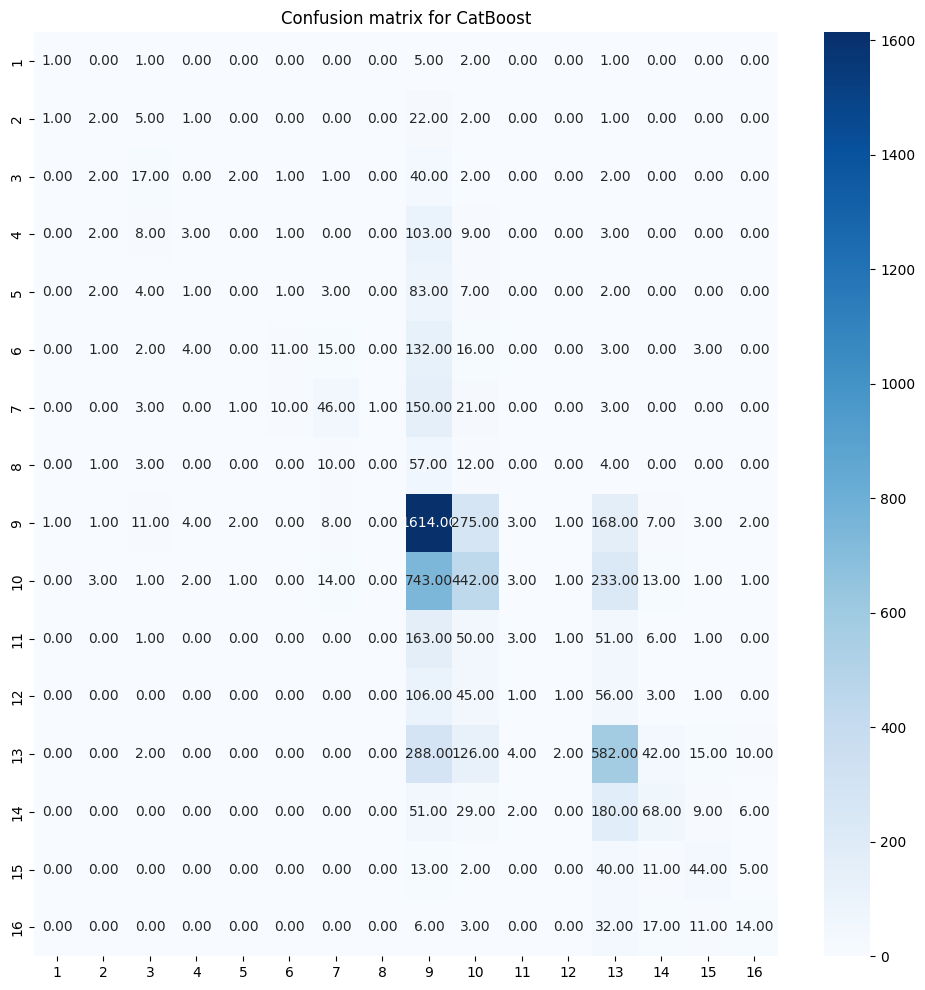

In [ ]:
plt.figure(figsize=(12,12))

cm = confusion_matrix(Y_validation, y_pred)

g = sns.heatmap(cm,
                annot=True, fmt = ".2f", cmap=plt.cm.Blues,
               xticklabels=sorted(Y_validation.unique()),
                yticklabels=sorted(Y_validation.unique())).set_title(
    "Confusion matrix for CatBoost")

Какие-то инсайты из неё получить можно. Например, мы видим, что модель почти никогда не предсказывает классы 1, 2 и 5, а ещё - что классы 9, 10 и 13 нередко путают друг с другом. Тем не менее, когда классов много и они не сбалансированы, читать эту матрицу не очень легко. А классы, как можно легко убедиться, не сбалансированы:

C:\Users\User\AppData\Local\Temp\ipykernel_3188\315389864.py:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x="education.num", data=df, palette = "muted")


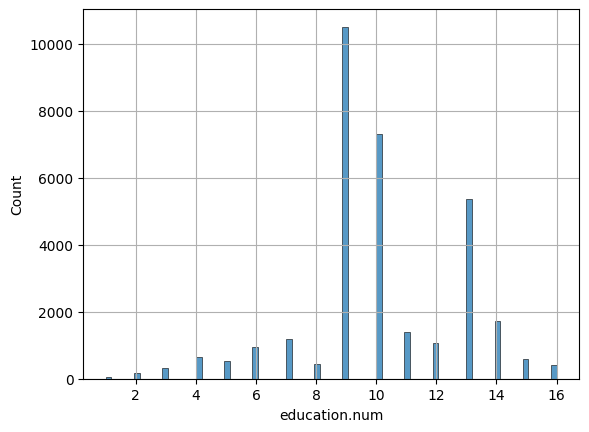

In [ ]:
sns.histplot(x="education.num", data=df, palette = "muted")
plt.grid()

Поэтому мы посмотрим, какие бывают способы агрегировать информацию из confusion matrix в одно число. Один из них вы уже знаете — это `balanced_accuracy_score`, который равен среднему `recall` по всем категориям. Иными словами, мы в каждой строке делим диагональный элемент на сумму элементов этой строки, а полученные числа усредняем.

In [ ]:
for i, category in enumerate(sorted(Y_validation.unique())):
    print(category, cm[i,i]/cm[i,:].sum())

1 0.1
2 0.058823529411764705
3 0.2537313432835821
4 0.023255813953488372
5 0.0
6 0.058823529411764705
7 0.19574468085106383
8 0.0
9 0.7685714285714286
10 0.30315500685871055
11 0.010869565217391304
12 0.004694835680751174
13 0.5434173669467787
14 0.19710144927536233
15 0.3826086956521739
16 0.1686746987951807


In [ ]:
balanced_accuracy_score(Y_validation, clf.predict(X_validation))

0.19184199649434006

Как и следовало ожидать, для многих классов всё весьма печально.

**2.1. $F_1$-мера для многоклассовых моделей**

Чтобы посчитать F-меру, нужны Precision и Recall, а их мы умеем считать только для бинарных классификаторов. Поэтому мы сделаем из одного многоклассового классификатора `N=число классов` штук бинарный "один против остальных". Для каждого посчитаем $TP_i$, $FN_i$, $FP_i$ и $TN_i$. Например, $TP_i$ - это `(i,i)`-й элемент confusion matrix, а $FP_i$ - это сумма элементов `i`-го столбца, кроме `(i,i)`-го.

In [ ]:
TP = np.diag(cm)
FP = np.sum(cm, axis=0) - np.diag(cm)
FN = np.sum(cm, axis=1) - np.diag(cm)
TN = np.sum(cm) - TP - FP - FN

submetrics = pd.DataFrame({'TP': TP, 'FP': FP, 'FN': FN, 'TN':TN},
                         index=sorted(Y_validation.unique()))
submetrics

,TP,FP,FN,TN
1,1,2,9,6501
2,2,12,32,6467
3,17,41,50,6405
4,3,12,126,6372
5,0,6,103,6404
6,11,13,176,6313
7,46,51,189,6227
8,0,1,87,6425
9,1614,1962,486,2451
10,442,601,1016,4454


Или можно было воспользоваться `multilabel_confusion_matrix`.

А дальше есть несколько стратегий:

1. *Micro*. Усредним значения всех $TP_i$, $FN_i$, $FP_i$ и $TN_i$. Получим четыре числа: $TP_{micro}$, $FN_{micro}$, $FP_{micro}$ и $TN_{micro}$, по ним посчитаем precision, recall и f-меру.

2. *Macro*. Посчитаем $precision_i$, $recall_i$ и $f1\_score_i$, а потом усредним их (по умолчанию просто усредним, но можно и с весами, зависящими от числа объектов в классах).

In [ ]:
micro_average = submetrics.mean(axis=0)
micro_precision = micro_average['TP'] / (micro_average['TP'] + micro_average['FP'])
micro_recall = micro_average['TP'] / (micro_average['TP'] + micro_average['FN'])
micro_f1 = (2*micro_precision*micro_recall) / (micro_precision + micro_recall)
print('f1_micro =', micro_f1)

f1_micro = 0.4372792875786888


In [ ]:
np.allclose(micro_f1, f1_score(Y_validation, y_pred, average='micro'))

True

Сошлось :D

In [ ]:
macro_precision = submetrics['TP'] / (submetrics['TP'] + submetrics['FP'] + 1e-20)
macro_recall = submetrics['TP'] / (submetrics['TP'] + submetrics['FN'] + 1e-20)
macro_f1 = np.mean((2*macro_precision*macro_recall) / (macro_precision + macro_recall + 1e-20))
print('f1_macro =', macro_f1)

f1_macro = 0.20582595302244014


In [ ]:
np.allclose(macro_f1, f1_score(Y_validation, y_pred, average='macro'), rtol=1e-5)

True

In [ ]:
import numpy as np
from collections import Counter
from itertools import combinations

def calculate_recall_macro(y_true, y_pred, num_classes):
    """
    Calculate recall_macro based on the true and predicted labels.
    """
    recalls = []
    for c in range(num_classes):
        tp = np.sum((y_pred == c) & (y_true == c))
        fn = np.sum((y_true == c) & (y_pred != c))
        if tp + fn == 0:
            recalls.append(0.0)
        else:
            recalls.append(tp / (tp + fn))
    return np.mean(recalls)

def find_min_recall_macro(y_true, num_classes, target_recall_micro=0.5):
    """
    Find the minimal possible recall_macro for a given dataset (y_true) and a fixed recall_micro.
    """
    # Total number of samples
    total_samples = len(y_true)
    total_tp_fn = Counter(y_true)  # TP + FN per class
    
    # Target TP (ensuring recall_micro = target_recall_micro)
    target_tp = int(total_samples * target_recall_micro)
    
    # Generate all possible class assignments for TP
    min_recall_macro = float('inf')
    best_assignment = None
    
    for class_combination in combinations(range(num_classes), r=1):
        # Assign TP to the selected class and others get 0
        y_pred = np.zeros_like(y_true)
        for cls in class_combination:
            y_pred[:target_tp] = cls
        
        # Calculate recall_macro for this assignment
        recall_macro = calculate_recall_macro(y_true, y_pred, num_classes)
        if recall_macro < min_recall_macro:
            min_recall_macro = recall_macro
            best_assignment = y_pred.copy()
    
    return min_recall_macro, best_assignment

# Test dataset
np.random.seed(42)
num_classes = 16
samples_per_class = 50
y_true = np.repeat(np.arange(num_classes), samples_per_class)  # Equal distribution of classes

# Calculate minimal recall_macro
min_recall_macro, best_assignment = find_min_recall_macro(y_true, num_classes)
min_recall_macro


0.0

Обратите внимание на добавки `1e-20`. Без них получилось бы совсем другое число (а вы понимаете, почему?).

Вот тут мы нарисовали значения F1-micro и F1-macro для кучи классификаторов. Можно убедиться, что микроусреднение оценивает качество значительно более оптимистично.

IndexError: invalid index to scalar variable.

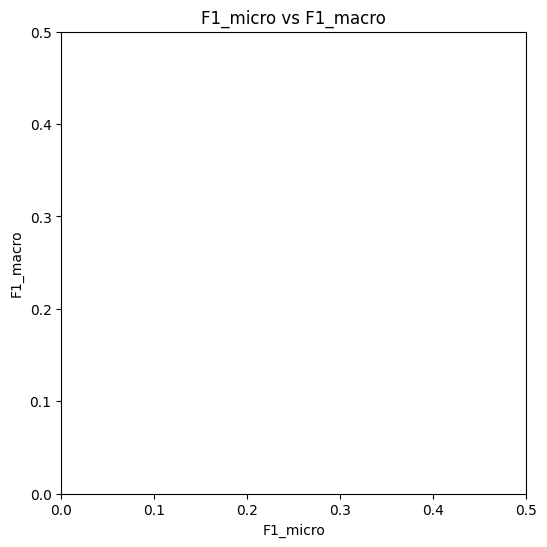

In [ ]:
plt.figure(figsize=(6,6))
plt.title('F1_micro vs F1_macro')
plt.xlabel('F1_micro')
plt.ylabel('F1_macro')
plt.xlim([0,0.5])
plt.ylim([0,0.5])

plt.scatter(micro_f1[1:], macro_f1[1:])

for i, txt in enumerate(names[1:]):
    plt.annotate(txt, (micro_f1[i + 1], macro_f1[i + 1]))

**8. (1 балл)** Найдите и сдайте в Контест минимально возможное значение `recall_macro` классификатора на валидационной выборке, если известно, что recall_micro = 0.5

В целом, до ответа можно догадаться, но если не получается, вы можете сформулировать оптимизационную задачу минимизации `recall_macro` при заданном значении `recall_micro` — это будет задача целочисленного линейного программирования. Решать её не так просто, но вы можете, например, воспользоваться `from scipy.optimize.linprog` для получения не целочисленного решения, а потом округлить; разница в `recall` будет не такая большая.

In [ ]:
import numpy as np
from scipy.optimize import linprog
from collections import Counter
k = 16
N = np.array(list(Counter(Y_validation).values()))
A_eq = np.ones((1, k)) 
b_eq = np.array([0.5 * np.sum(N)]) 
c = 1 / (k * N) 
bounds = [(0, N[i]) for i in range(k)]
result = linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method="highs")
if result.success:
    TP = result.x
    recall_macro = np.mean(TP / N)
    print("Минимально возможный recall_macro:", recall_macro)
else:
    print("Ошибка оптимизации:", result.message)


Минимально возможный recall_macro: 0.11207561728395062


In [ ]:
print(submetrics['TP'].sum(), submetrics['TP'].sum() + submetrics['FN'].sum())

2848 6513


In [ ]:
submetrics['TP'] + submetrics['FN']

1       10
2       34
3       67
4      129
5      103
6      187
7      235
8       87
9     2100
10    1458
11     276
12     213
13    1071
14     345
15     115
16      83
dtype: int64

$$recall\_micro = \frac{\sum_iTP_i}{\sum_i(\text{number of elements of class i})}$$

То есть 

$$recall\_micro = \frac{\sum_iTP_i}{6513}$$

В свою очередь,

$$recall\_macro = mean\left(\frac{TP_i}{\text{number of elements of class i}}\right)$$

Ну, и получается задача линейного программирования

In [ ]:
from scipy.optimize import linprog

**2.2. Cohen's Kappa**



В основе этой метрики лежит сравнение accuracy классификатора с некоторой "ожидаемой" accuracy. Делается это следующим образом:


1) Пусть $p_0$ — число верно классифицированных объектов (то есть сумма диагональных элементов confusion matrix).

2) Пусть $p_e$ — это сумма диагональных элементов матрицы, `(i,j)`-й элемент которой равен

`(доля классифицированных i-м классом) * (число элементов класса j)`

то есть, грубо говоря, тому, каким было бы число верно классифицированных объектов у модели, которая расставляла бы метки случайным образом, но с такими же вероятностями, как у исходного классификатора.

Тогда `cohen_kappa_score` определяется как

$$\kappa = 1 - \frac{1 - p_0}{1 - p_e}$$

`cohen_kappa` слабее, чем `f1_macro` и `balanced_accuracy` штрафует за ошибки на маленьких классах, но в то же время сильнее — за равномерно разбросанные по классам ошибки.

Если приравнять выражение для `cohen_kappa_score` к нулю, то вы получите конструкцию вполне определённого (рандомизированного) классификатора (который и выдаёт пресловутую ожидаемую accuracy). Реализуйте его, убедитесь, что `cohen_kappa_score` примерно нулевой. 

**9. (1 балл)** Сдайте в контест значение `Accuracy` для этого классификатора.

Сравните его с Accuracy полностью случайного классификатора. А теперь сравните построенный вами и случайный классификатор по метрикам `cohen_kappa_score`, `balanced_accuracy` и `f1_macro`.

In [ ]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin

class RandomExpectedAccuracyClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self):
        self.class_probs = None

    def fit(self, X, y):
        """
        Запоминает распределение классов.
        :param X: Фичи (игнорируются, т.к. классификатор случайный).
        :param y: Метки классов.
        """
        # Вычисляем вероятности классов (доля каждого класса в выборке)
        unique, counts = np.unique(y, return_counts=True)
        self.class_probs = counts / counts.sum()
        self.classes_ = unique
        return self

    def predict(self, X):
        """
        Предсказывает классы для объектов.
        :param X: Фичи (игнорируются).
        :return: Массив предсказанных меток классов.
        """
        n_samples = X.shape[0]
        return np.random.choice(self.classes_, size=n_samples, p=self.class_probs)

    def predict_proba(self, X):
        """
        Возвращает вероятности классов для каждого объекта.
        :param X: Фичи (игнорируются).
        :return: Массив shape (n_samples, n_classes), вероятности для каждого класса.
        """
        n_samples = X.shape[0]
        return np.tile(self.class_probs, (n_samples, 1))

clf = RandomExpectedAccuracyClassifier()
clf.fit(X_train, Y_train)
y_pred = clf.predict(X_validation)
accuracy = accuracy_score(y_pred=y_pred, y_true=Y_validation)
accuracy

0.1845539689851067

In [ ]:
Y_pred_bad = np.zeros(Y_validation.shape)
for cl in range(16):
    Y_pred_bad += np.random.choice(list(range(1, 17)), Y_validation.shape,
                                  p=np.sum(cm, axis=1) / np.sum(cm)) *\
        (Y_validation == cl + 1)
    

Давайте проведём несколько синтетических экспериментов, чтобы прояснить поведение Cohen Kappa. Для начала посмотрим, какие значения она и некоторые другие популярные метрики будут принимать, если ошибки происходят только на одном не очень популярном классе (например, на 6-м).

In [ ]:
fantasy_balanced_accuracies = []
fantasy_f1_micros = []
fantasy_f1_macros = []
fantasy_kappas = []

p_error_values = np.arange(0, 1, 0.1)

for p_error_on_6 in p_error_values:
    
    error_mask = (
        np.random.choice(2, Y_validation.shape, p=(1 - p_error_on_6, p_error_on_6)) *
        (Y_validation == 6)
    )
    
    Y_fantasy_pred = (
        error_mask * np.random.choice(np.unique(Y_validation)) +
        (1 - error_mask) * Y_validation
    )
    fantasy_balanced_accuracies.append(balanced_accuracy_score(Y_validation, Y_fantasy_pred))
    fantasy_f1_micros.append(f1_score(Y_validation, Y_fantasy_pred, average='micro'))
    fantasy_f1_macros.append(f1_score(Y_validation, Y_fantasy_pred, average='macro'))
    fantasy_kappas.append(cohen_kappa_score(Y_validation, Y_fantasy_pred))

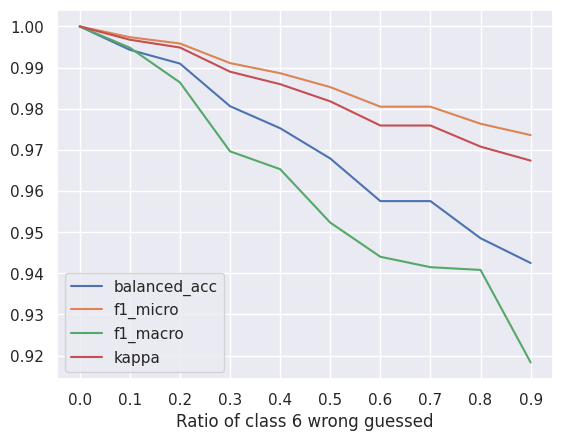

In [ ]:
plt.xlabel('Ratio of class 6 wrong guessed')
plt.xticks(p_error_values)

plt.plot(p_error_values, fantasy_balanced_accuracies, label='balanced_acc')
plt.plot(p_error_values, fantasy_f1_micros, label='f1_micro')
plt.plot(p_error_values, fantasy_f1_macros, label='f1_macro')
plt.plot(p_error_values, fantasy_kappas, label='kappa')
plt.legend()

Видим, что Cohen Kappa действительно менее чувствительна к ошибкам на малом классе, чем `f1_macro` или `balanced_accuracy` (вы ведь понимаете, почему эти две метрики реагируют сильнее?).

Теперь давайте посмотрим, что будет происходить в случае не зависящей от класса ошибки, и убедимся, что каппа убывает быстрее.

In [ ]:
fantasy_balanced_accuracies = []
fantasy_f1_micros = []
fantasy_f1_macros = []
fantasy_kappas = []

p_error_values = np.arange(0, 0.5, 0.1)

for p_error_on_6 in p_error_values:
    
    error_mask = (
        np.random.choice(2, Y_validation.shape, p=(1 - p_error_on_6, p_error_on_6))
    )
    
    Y_fantasy_pred = (
        error_mask * np.random.choice(np.unique(Y_validation)) +
        (1 - error_mask) * Y_validation
    )
    fantasy_balanced_accuracies.append(balanced_accuracy_score(Y_validation, Y_fantasy_pred))
    fantasy_f1_micros.append(f1_score(Y_validation, Y_fantasy_pred, average='micro'))
    fantasy_f1_macros.append(f1_score(Y_validation, Y_fantasy_pred, average='macro'))
    fantasy_kappas.append(cohen_kappa_score(Y_validation, Y_fantasy_pred))

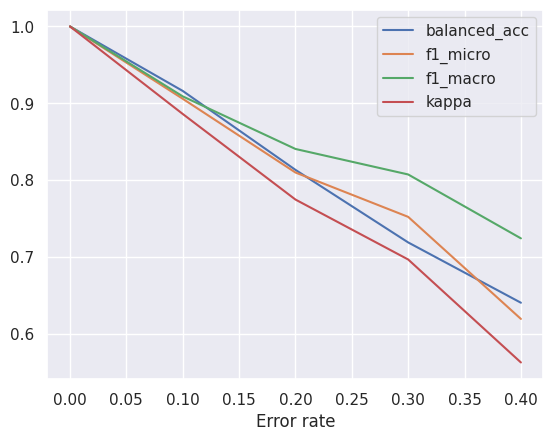

In [ ]:
plt.xlabel('Error rate')

plt.plot(p_error_values, fantasy_balanced_accuracies, label='balanced_acc')
plt.plot(p_error_values, fantasy_f1_micros, label='f1_micro')
plt.plot(p_error_values, fantasy_f1_macros, label='f1_macro')
plt.plot(p_error_values, fantasy_kappas, label='kappa')
plt.legend()

In [ ]:
n_classes = cm.shape[0]
sum0 = np.sum(cm, axis=0)
sum1 = np.sum(cm, axis=1)
expected = np.outer(sum0, sum1) / np.sum(sum0)

w_mat = np.ones([n_classes, n_classes], dtype=int)
w_mat.flat[:: n_classes + 1] = 0

k = np.sum(w_mat * cm) / np.sum(w_mat * expected)
1 - k

0.24984646615721906

In [ ]:
cohen_kappa_score(Y_validation, y_pred)

0.24984646615721906

In [ ]:
w_mat

array([[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]])

Всё на этом, лабораторная закончена.